### Imports and configuration

In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import pickle
import rasterio as rio

from matplotlib.patches import Rectangle
from rasterio.enums import Resampling
from sklearn.metrics import mean_squared_error

matplotlib.rc('animation', html='jshtml')
matplotlib.rc('animation', embed_limit=1000)
matplotlib.rc('figure', dpi=150)

binary_cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
confusion_cmap = matplotlib.colors.ListedColormap(['gray', 'green', 'red', 'blue'])
transition_cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'orange'])

### Helper functions

In [41]:
# proj crs NAD 1983 UTM Zone 18N
# geographic crs NAD 1983

def couple_transition_anim(surge_inun, riv_inun, ratio_array, alpha):

    # earlier operations moved out of the loop for performance

    # vary alpha (see eqn. 2 from SI 2022 paper)
    # calculate compound inundation accounting for transition zone
    # implement eqn. 2 from SI 2022 paper
    compound_inun = np.where(
        (ratio_array > 1) & (surge_inun != 0), # coastal zone
        0,
        np.where(
            (ratio_array <= alpha*riv_inun) & (riv_inun != 0), # hydrologic zone
            1,
            np.where(
                (ratio_array <= 1 & (ratio_array > alpha*riv_inun)) & (surge_inun != 0) & (riv_inun != 0), # transition zone
                2,
                np.nan, # else assign NaN
        )))

    return np.ma.masked_array(compound_inun,msk)

def couple_transition(surge_inun, riv_inun, ratio_array, alpha):

    # earlier operations moved out of the loop for performance

    # vary alpha (see eqn. 2 from SI 2022 paper)
    # calculate compound inundation accounting for transition zone
    # implement eqn. 2 from SI 2022 paper
    compound_inun = np.where(
        (ratio_array > 1) & (surge_inun != 0), # coastal zone
        surge_inun,
        np.where(
            (ratio_array <= alpha*riv_inun) & (riv_inun != 0), # hydrologic zone
            riv_inun,
            np.where(
                (ratio_array <= 1 & (ratio_array > alpha*riv_inun)) & (surge_inun != 0) & (riv_inun != 0), # transition zone
                ratio_array*np.maximum(surge_inun, riv_inun) + (1 - ratio_array)*(surge_inun + riv_inun),
                np.nan, # else assign NaN
        )))

    return np.ma.masked_array(compound_inun,msk)

# makes inundation depth array binary
# 0 is not inundated and 1 is inundated
def make_binary(in_array):
    binary_array = in_array.copy().astype('uint8')
    binary_array = np.where(binary_array <= int(0), int(0), int(1))
    binary_array[binary_array==np.nan] = int(0)
    if isinstance(in_array, np.ma.MaskedArray):
        binary_array = np.ma.masked_array(binary_array, in_array.mask).astype('uint8')
    return binary_array.astype('uint8')

def imshow_binary_array(in_array, save_path=None):
    fig, ax = plt.subplots()

    cax = ax.imshow(
        in_array,
        vmin = 0,
        vmax = 1,
        cmap = binary_cmap,
        interpolation = 'nearest'
        )

    cbar = fig.colorbar(
        cax,
        ticks=[0,.25,0.5,0.75,1],
        ax=ax,
        fraction=0.046,
        pad=0.03
        )

    cbar.ax.set_yticklabels(
        ['','Not inundated','','Inundated',''],
        rotation=90,
        va='center' # set vertical alignment
        )

    if save_path is not None:
        fig.tight_layout()
        plt.savefig(save_path, facecolor = 'w')
        
    plt.show()


def notnan(a):
    return a[~np.isnan(a)]

### Read and clean input datasets

In [13]:
surge_fpath = 'data_github/florence_surge_nhc_max_internal_mask.tif'
riv_fpath = 'data_github/030202_201809192100_depth_map_projUTM18n.tif'

with rio.open(surge_fpath) as ds_in:
    surge_inun = ds_in.read(1, masked=True)
    surge_inun_profile = ds_in.profile
msk = surge_inun.copy().mask # save mask, will get wiped out on next lines
surge_inun[surge_inun>3.4e+38] = np.nan # set nodata
surge_inun[surge_inun < 0] = np.nan
surge_inun = np.ma.masked_array(surge_inun, msk)
# save mask with GDAL convetion for writing later
# https://rasterio.readthedocs.io/en/latest/topics/masks.html
w_msk = (~surge_inun.mask * 255).astype('uint8')

with rio.open(riv_fpath) as ds_in:
    riv_inun = ds_in.read(1, masked=True)
riv_inun[riv_inun>3.4e+38] = np.nan # set nodata
riv_inun[riv_inun<0] = np.nan

# give riv_inun one extra row and col to match shapes with surge_inun
# this is due to how ArcGIS projected raster
# extra row and col will get masked out when written to .tif
# newrow = np.empty(riv_inun.shape[1])
# newrow.fill(np.nan)
# riv_inun = np.vstack([riv_inun,newrow])

# newcol = np.empty([riv_inun.shape[0],1])
# newcol.fill(np.nan)
# riv_inun = np.hstack([riv_inun,newcol])

newrow = np.empty(riv_inun.shape[1])
newrow.fill(np.nan)
riv_inun = np.vstack([newrow,riv_inun])

newcol = np.empty([riv_inun.shape[0],1])
newcol.fill(np.nan)
riv_inun = np.hstack([newcol,riv_inun])

# avoid divide by zero errors
ratio_adj = 0 # .001 # 0.001 m = 0.04 in
ratio_array = (surge_inun + ratio_adj) / (riv_inun + ratio_adj)

### Run coupling function

In [14]:
alpha01 = 0.1

florence_max_01 = couple_transition_anim(
    surge_inun = surge_inun,
    riv_inun = riv_inun,
    ratio_array = ratio_array,
    alpha = alpha01 # see eqn. 2 in SI 2022 paper
)

# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_max_alpha_01.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_01,1)
        ds_out.write_mask(w_msk)

alpha04 = 0.4

florence_max_04 = couple_transition_anim(
    surge_inun = surge_inun,
    riv_inun = riv_inun,
    ratio_array = ratio_array,
    alpha = alpha04 # see eqn. 2 in SI 2022 paper
)

# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_max_alpha_04.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_04,1)
        ds_out.write_mask(w_msk)b

In [17]:
alpha01 = 0.1

florence_max_01 = couple_transition(
    surge_inun = surge_inun,
    riv_inun = riv_inun,
    ratio_array = ratio_array,
    alpha = alpha01 # see eqn. 2 in SI 2022 paper
)

# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_depth_max_alpha_01.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_01,1)
        ds_out.write_mask(w_msk)

alpha04 = 0.4

florence_max_04 = couple_transition(
    surge_inun = surge_inun,
    riv_inun = riv_inun,
    ratio_array = ratio_array,
    alpha = alpha04 # see eqn. 2 in SI 2022 paper
)

# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_depth_max_alpha_04.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_04,1)
        ds_out.write_mask(w_msk)

In [36]:
florence_max_01_binary = make_binary(florence_max_01)
# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_binary_max_alpha_01.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_01_binary,1)
        ds_out.write_mask(w_msk)

florence_max_04_binary = make_binary(florence_max_04)
# write raster with internal mask (no .msk sidecar)
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open('data_github/florence_binary_max_alpha_04.tif', 'w', **surge_inun_profile) as ds_out:
        ds_out.write(florence_max_04_binary,1)
        ds_out.write_mask(w_msk)

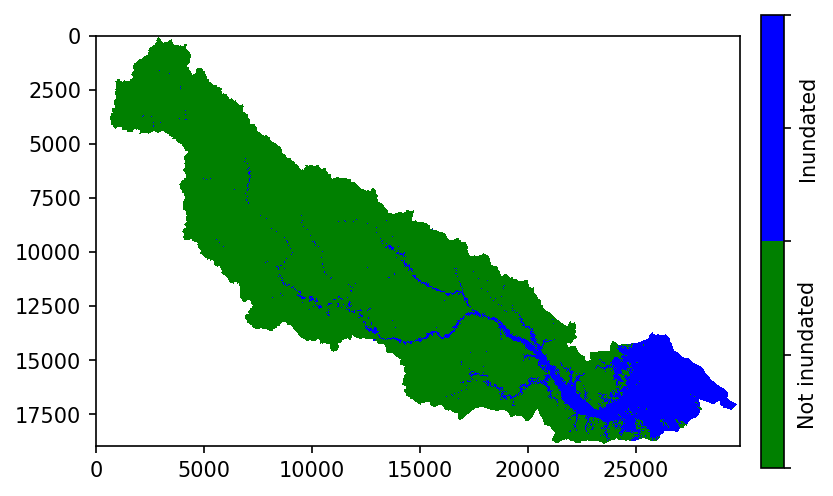

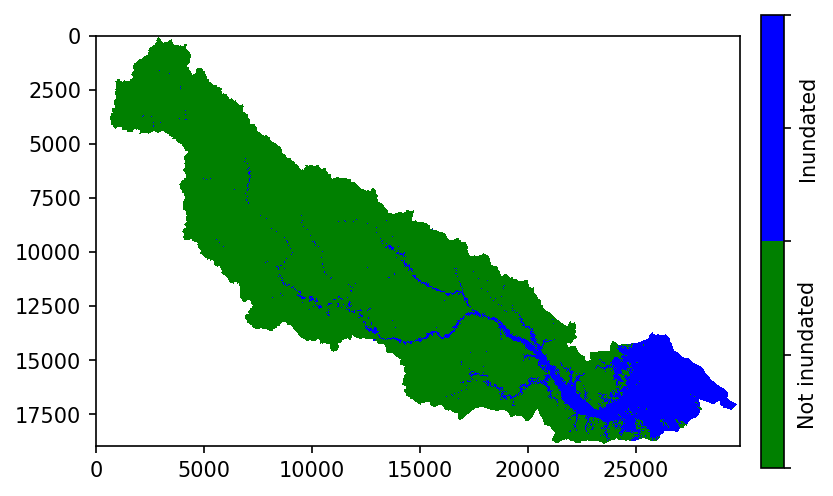

In [42]:
imshow_binary_array(florence_max_01_binary)
imshow_binary_array(florence_max_04_binary)

### Make initial plot on which to display animation

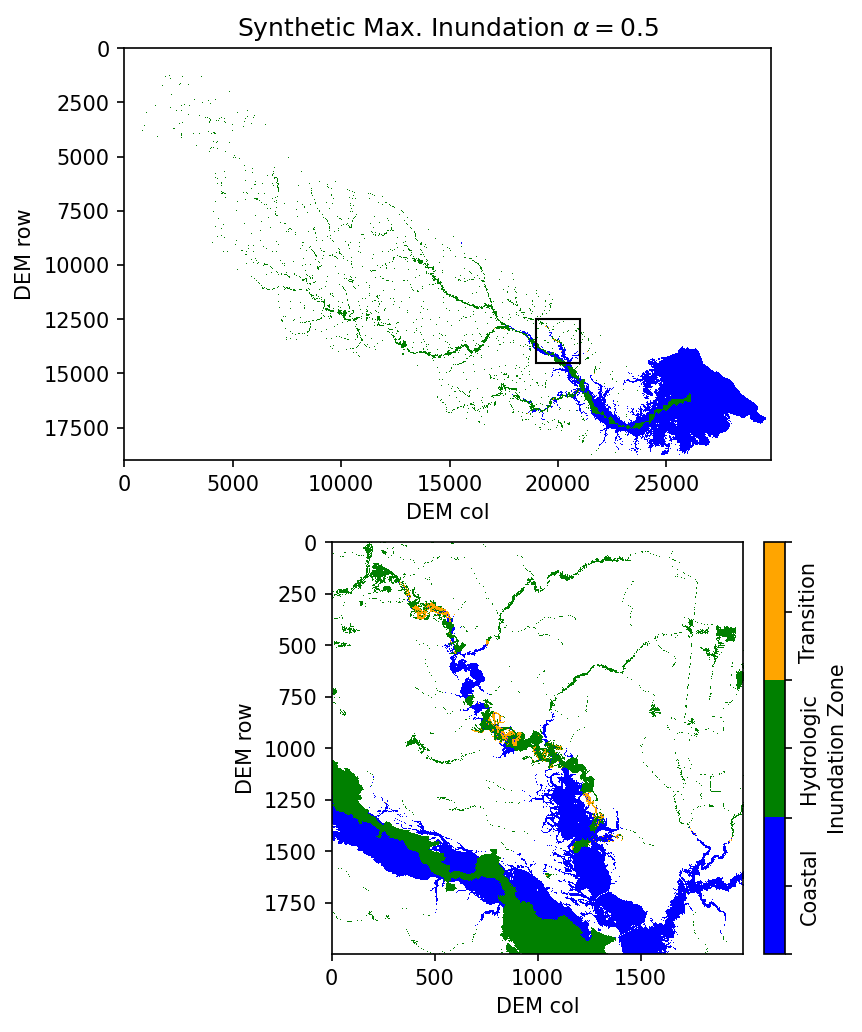

In [5]:
plt.close('all')

fig, ax = plt.subplots(2,1,figsize=(6,8),facecolor='w')

# detail window
rec_tl = (19000,12500) # top left (x, y)
dw, dh = 2000, 2000 # width, height of rec

cax0 = ax[0].imshow(
    florence_max,
    vmin=0,
    vmax=2,
    cmap=transition_cmap,
    interpolation='nearest'
    )

ax[0].set(
    title=fr'Synthetic Max. Inundation $\alpha = {alpha}$',
    xlabel='DEM col',
    ylabel='DEM row'
    )

# plot detail window on full map
ax[0].add_patch(Rectangle(
    rec_tl,
    dw,dh,
    fill=False,
    color='k')
    )

cax1 = ax[1].imshow(
    florence_max[
        rec_tl[1]:rec_tl[1]+dh,
        rec_tl[0]:rec_tl[0]+dw
        ],
    vmin=0,
    vmax=2,
    cmap=transition_cmap,
    interpolation='nearest'
        )

cbar = fig.colorbar(
    cax1,
    label='Inundation Zone',
    ticks=[0,0.33,0.663,1,1.33,1.66,2],
    ax=ax[1],
    fraction=0.046,
    pad=0.03
    )

cbar.ax.set_yticklabels(
    ['','Coastal','','Hydrologic','','Transition',''],
    rotation=90,
    va='center' # set vertical alignment
    )

ax[1].set(
    xlabel='DEM col',
    ylabel='DEM row'
    )

plt.show()

# # write raster with internal mask (no .msk sidecar)
# with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
#     with rio.open('data_github/synth_max_transition_alpha_05_noadj.tif', 'w', **surge_inun_profile) as ds_out:
#         ds_out.write(florence_max,1)
#         ds_out.write_mask(w_msk)

### Vary alpha for calcs

In [10]:
alpha_step = 0.01
alphalist = np.arange(
    0,
    0.5+alpha_step,
    alpha_step
    )
alphalist = np.append(alphalist,1)
alphalist

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 1.  ])

### Define animation loop called at each frame

In [7]:
def animate(i):
    
    alpha = alphalist[i]

    florence_max = couple_transition_anim(
        surge_inun = surge_inun,
        riv_inun = riv_inun,
        ratio_array = ratio_array,
        alpha = alpha # see eqn. 2 in SI 2022 paper
        )

    cax0.set_data(
        florence_max
        )

    cax1.set_data(
        florence_max[
            rec_tl[1]:rec_tl[1]+dh,
            rec_tl[0]:rec_tl[0]+dw
        ],
        )
        
    ax[0].set(
        title=fr'Synthetic Max. Inundation $\alpha = {round(alpha,2)}$'
        )

    return (cax0,cax1,)

### Make animation object

In [8]:
frames = list(range(len(alphalist)))

anim = matplotlib.animation.FuncAnimation(
    fig,
    animate, 
    frames=frames,
    interval=100,
    blit=True
    )

### Save animation

In [10]:
plt.close('all')
anim.save('data_github/alpha_anim_3fps.gif', writer='imagemagick', fps=3)

### Save data for plots

In [45]:
cols = ['alpha_val','n_coastal','n_hydro','n_trans']
df = pd.DataFrame(columns=cols)

for i, alpha in enumerate(alphalist):

    florence_max = couple_transition_anim(
        surge_inun = surge_inun,
        riv_inun = riv_inun,
        ratio_array = ratio_array,
        alpha = alpha # see eqn. 2 in SI 2022 paper
        )

    _, counts = np.unique(florence_max, return_counts=True)

    print(counts[:3])
    # n_coastal = counts[0]
    # n_hydro = counts[1]
    # n_trans = counts[2]

    # df['alpha_val'][i] = alpha
    # df['n_coastal'][i] = n_coastal
    # df['n_hydro'][i] = n_hydro
    # df['n_trans'][i] = n_trans

    del(florence_max)

# df.to_csv(
#     'data_github/sensitivity_analysis.csv',
#     index=False,
#     sep=','
#     )


[19009863  5732227  1871152]
[19009863  6288272  1315107]
[19009863  7183844   419535]
[19009863  7429054   174325]
[19009863  7462837   140542]
[19009863  7502721   100658]
[19009863  7525234    78145]
[19009863  7557944    45435]
[19009863  7565050    38329]
[19009863  7571033    32346]
[19009863  7574737    28642]
[19009863  7578167    25212]
[19009863  7581597    21782]
[19009863  7584640    18739]
[19009863  7586392    16987]
[19009863  7587590    15789]
[19009863  7588883    14496]
[19009863  7590045    13334]
[19009863  7591069    12310]
[19009863  7591817    11562]
[19009863  7592453    10926]


In [2]:
# saved output from above to csv

df = pd.read_csv(
    'data_github/sensitivity_analysis2.csv',
    index_col=0
    )

df.columns

Index(['n_coastal', 'n_hydro', 'n_trans'], dtype='object')

In [3]:
df

,n_coastal,n_hydro,n_trans
alpha_val,,,
0.00,19009863,5732227,1871152
0.01,19009863,5793543,1809836
0.02,19009863,5899789,1703590
0.03,19009863,6035266,1568113
0.04,19009863,6176170,1427209
0.05,19009863,6288272,1315107
0.06,19009863,6481447,1121932
0.07,19009863,6591424,1011955
0.08,19009863,6715428,887951


In [27]:
df['n_hydro_norm'] = 100*df['n_hydro']/df['n_hydro'].max()
df['n_trans_norm'] = 100*df['n_trans']/df['n_trans'].max()

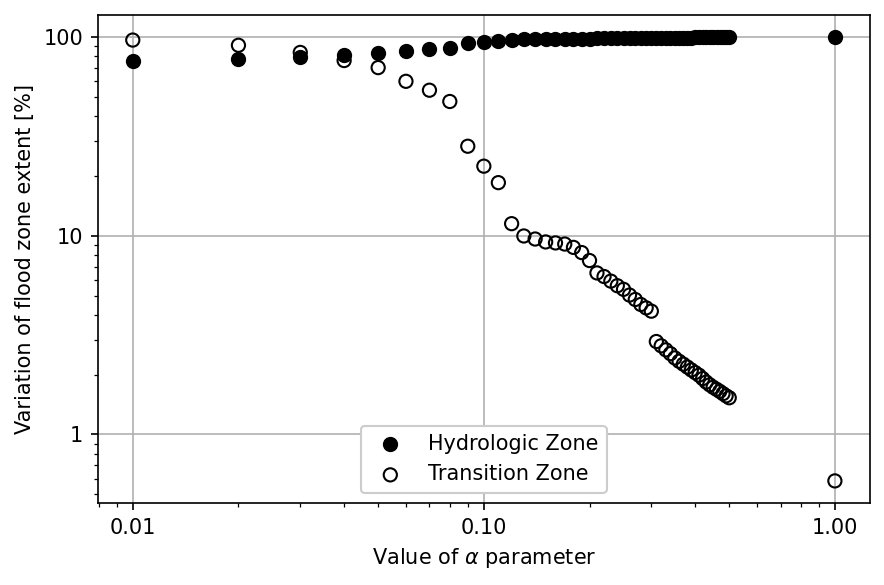

In [37]:
fig, ax = plt.subplots()
plt.rc('axes.formatter', useoffset=False)

ax.scatter(
    df.index,
    df.n_hydro_norm,
    s=40,
    facecolors='k',
    edgecolors='k',
    label='Hydrologic Zone'
    )

ax.set(
    ylabel="Variation of flood zone extent [%]",
    xlabel=r"Value of $\alpha$ parameter"
)


ax.scatter(
    df.index,
    df.n_trans_norm,
    s=40,
    facecolors='none',
    edgecolors='k',
    label='Transition Zone'
    )

ax.grid()
ax.set_axisbelow(True)

ax.legend(loc='lower center',framealpha=1)

ax.set_yscale('log')
ax.set_xscale('log')

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)


fig.tight_layout()


fig.savefig(
    'data_github/alpha_sensitivity_new.png',
    facecolor='w'
    )
